In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow as tf

In [3]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow).
random_seed = 2
tf.keras.utils.set_random_seed(random_seed)

In [4]:
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from plot_losses import PlotLosses

## Keras modules

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten

## Cargo datos

In [6]:
# Descomprimir data fashion-mnist-itba-lab-ml-2018b.zip y luego entrar a la carpeta 
# y descomprimir los zips de adentro
folder = './fashion-mnist-itba-lab-ml-2018b/'
!ls {folder}

test_images.npy      train_images.npy     train_labels.csv
test_images.npy.zip  train_images.npy.zip


In [7]:
x = np.load(folder + 'train_images.npy')
y = np.loadtxt(folder + 'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder + 'test_images.npy')

## Lo llevo a formato de imágenes de 28 x 28 x 1

In [8]:
x.shape

(60000, 28, 28)

In [9]:
x = np.expand_dims(x, axis=3)
x.shape

(60000, 28, 28, 1)

In [10]:
x_test = np.expand_dims(x_test, axis=3)
x_test.shape

(10000, 28, 28, 1)

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

## Paso a float

In [12]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [13]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

## Red neuronal: CNN LeNet-5

In [14]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(28,28,1), padding='same'))

model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))

model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=120, activation='tanh'))

model.add(Dense(units=84, activation='tanh'))

model.add(Dense(units=10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_valid, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='checkpoint.mnist-cnn.hdf5', verbose=1, save_best_only=True)

In [17]:
x_train.shape

(54000, 28, 28, 1)

In [18]:
y_train_categorical.shape

(54000, 10)

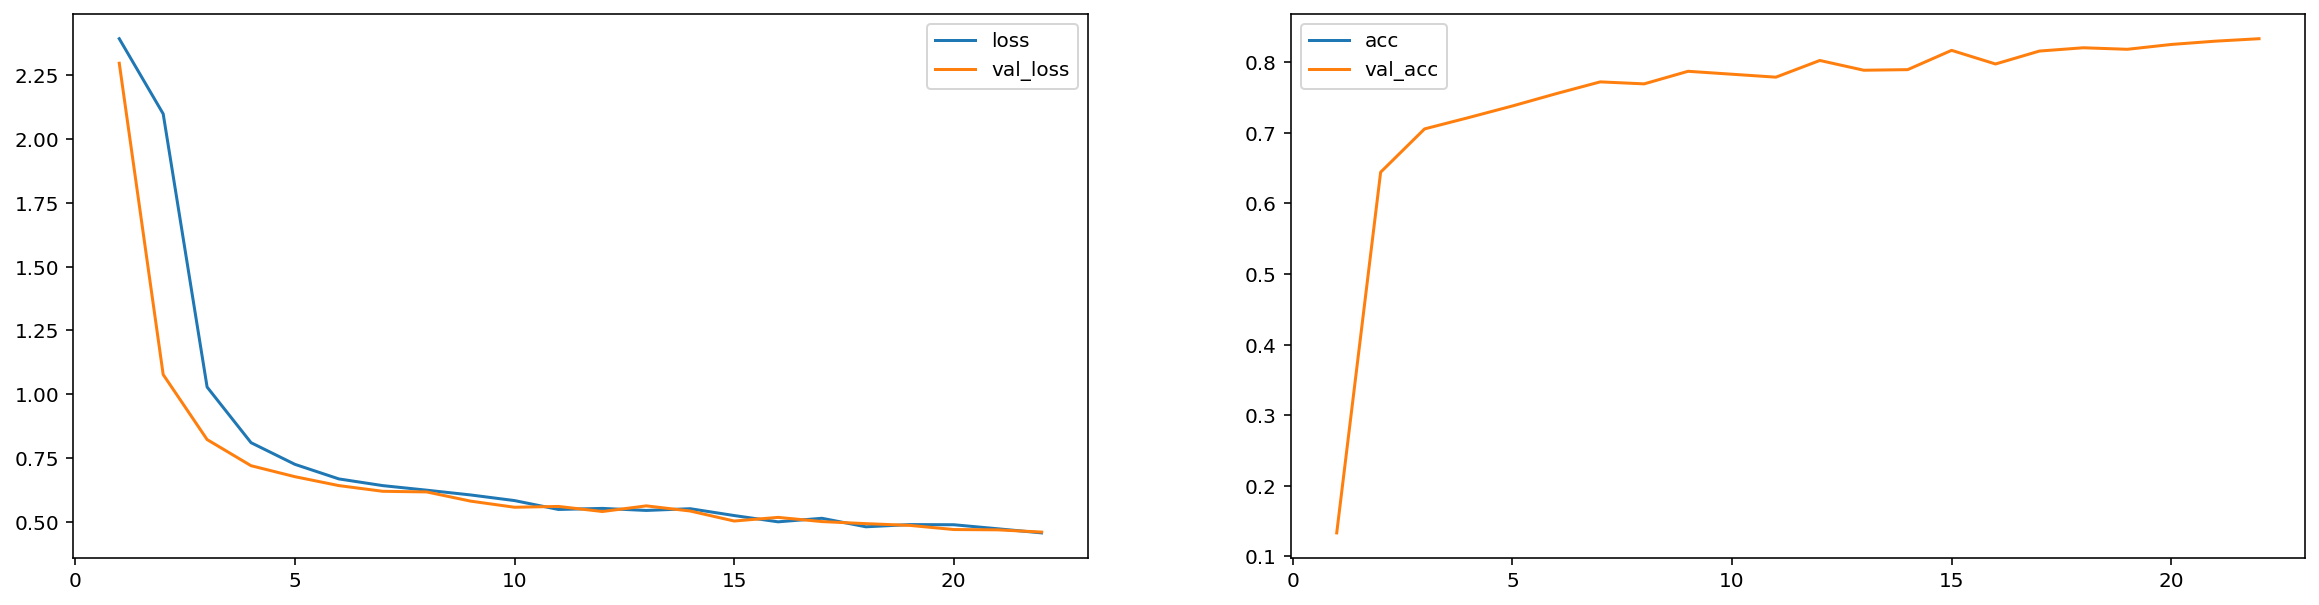


Epoch 1: val_loss improved from inf to 0.46681, saving model to checkpoint.mnist-cnn.hdf5
422/422 [==============================] - 16s 37ms/step - loss: 0.4602 - accuracy: 0.8338 - val_loss: 0.4668 - val_accuracy: 0.8292


In [19]:
batch_size = 128
epocs = 1

model.fit(x_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[plot_losses, checkpointer],
    )

In [20]:
model.load_weights('checkpoint.mnist-cnn.hdf5')

In [21]:
loss, acc = model.evaluate(x_valid, y_val_categorical)

188/188 [==============================] - 0s 2ms/step - loss: 0.4668 - accuracy: 0.8292


In [22]:
print(acc)
# 0.8234999775886536

0.8291666507720947


In [23]:
test_prediction = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [24]:
test_labels = np.argmax(test_prediction, axis = 1)

In [25]:
import pandas as pd
df = pd.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission.csv", sep=',',index=True,  index_label='Id')